In [2]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


with open('../data/training_data.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('../data/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

with open('../data/training_labels.pkl', 'rb') as f:
    train_labels = pickle.load(f)
    


K_train = np.load('../data/kernel_matrix.npy')
K_test = np.load('../data/test_kernel_matrix.npy')
K_train_test = np.load('../data/test_train_kernel_matrix.npy')

In [3]:
import os
import sys

if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.abspath('..'))

In [4]:
from src.kernels import VertexHistogramKernel

In [4]:
K_train = VertexHistogramKernel()(train_data, train_data)
np.save('../data/K_train_vertex.npy', K_train)

K_test = VertexHistogramKernel()(test_data, test_data)
np.save('../data/K_test_vertex.npy', K_test)

K_train_test = VertexHistogramKernel()(train_data, test_data)
np.save('../data/K_train_test_vertex.npy', K_train_test)


KeyboardInterrupt: 

In [5]:
class knn:
        
        def __init__(self, kernel, k=3) -> None:
            self.k = k
            self.kernel = kernel
            
        def fit(self, X, y):
            self.X = X
            self.y = y

            return self
        
        def compute_distance(self, x, base):
            k = self.kernel(x,x)
            return [k+self.kernel(b,b)-2*self.kernel(x, b) for b in base]
        
        def predict(self, X):
            y_pred = []
            score_list = []
            for x in tqdm(X):
                scores = np.array(self.compute_distance(x, self.X))
                idx = np.argsort(scores)[:self.k]
                y_pred.append((self.y[idx].mean()>.5).astype(int))
                score_list.append(scores)
            return np.array(y_pred), np.array(score_list)
        
        def score(self, X, y):
            return np.mean(self.predict(X)[0]==y)


In [6]:
np.sum(train_labels==0)/len(train_labels)


0.9075

In [7]:
def knn(K_train, K_test, K_train_test,y_train, k=3):
    y_pred = []
    for i in range(K_test.shape[0]):
        dists = np.diag(K_train) + K_test[i, i] - 2 * K_train_test[i, :]
        idx = np.argsort(dists)[:k]
        y_pred.append((y_train[idx].mean()>.5).astype(int))
    return np.array(y_pred)


In [101]:
np.save("pred_1_knn.npy", knn(K_train, K_test, K_train_test, train_labels, k=1))

In [41]:
#get stratified kfold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(train_data, train_labels):
    K_train_eval = K_train[train_index][:, train_index]
    K_test_eval = K_train[test_index][:, test_index]
    K_train_test_eval = K_train[train_index][:, test_index].T
    y_train_eval = train_labels[train_index]
    #print(K_train_eval.shape, K_test_eval.shape, K_train_test_eval.shape, y_train_eval.shape)
    y_pred = knn(K_train_eval, K_test_eval, K_train_test_eval, y_train_eval, k=1)
    y_test_eval = train_labels[test_index]
    print(f"Nb of 1 in y_test: {np.sum(y_test_eval==1)}")
    print(f"Nb of 1 in y_pred: {np.sum(y_pred==1)}")
    print(np.mean(y_pred==y_test_eval))



Nb of 1 in y_test: 111
Nb of 1 in y_pred: 30
0.9258333333333333
Nb of 1 in y_test: 111
Nb of 1 in y_pred: 48
0.9291666666666667
Nb of 1 in y_test: 111
Nb of 1 in y_pred: 50
0.9308333333333333
Nb of 1 in y_test: 111
Nb of 1 in y_pred: 48
0.9391666666666667
Nb of 1 in y_test: 111
Nb of 1 in y_pred: 39
0.9216666666666666


In [6]:
K_train_eval = K_train[:60, :60]
K_test_eval = K_test[60:90, 60:90]
K_train_test_eval = K_train[60:90, :60]
y_test = train_labels[60:90]

y_pred = knn(K_train_eval, K_test_eval, K_train_test_eval, k=3)

100%|██████████| 30/30 [00:00<00:00, 14163.57it/s]


In [8]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score

In [9]:
K_train = np.load('../data/kernel_matrix.npy')*np.load('../data/K_train_graph_hist.npy')
K_test = np.load('../data/test_kernel_matrix.npy')*np.load('../data/K_test_graph_hist.npy')
K_train_test = np.load('../data/test_train_kernel_matrix.npy')*np.load('../data/K_train_test_graph_hist.npy')

In [132]:
K_train_WL = np.abs(np.load('../data/WL_train.npy'))
#K_train_WL /= np.diag(K_train_WL).reshape(-1,1)

K_test_WL = np.abs(np.load('../data/WL_test.npy'))
#K_test_WL /= np.diag(K_test_WL).reshape(-1,1)

K_train_test_WL = np.abs(np.load('../data/WL_test_train.npy'))
#K_train_test_WL /= np.diag(K_train_test_WL).reshape(-1,1)

In [133]:
K_train_graph = np.load('../data/K_train_graph_hist.npy')
#K_train_graph /= np.diag(K_train_graph).reshape(-1,1)

K_test_graph = np.load('../data/K_test_graph_hist.npy')
#K_test_graph /= np.diag(K_test_graph).reshape(-1,1)

K_train_test_graph = np.load('../data/K_train_test_graph_hist.npy')
#K_train_test_graph /= np.diag(K_train_test_graph).reshape(-1,1)

In [134]:
K_train_vertex = np.load('../data/K_train_vertex.npy')
#K_train_vertex /= np.diag(K_train_vertex).reshape(-1,1)

K_test_vertex = np.load('../data/K_test_vertex.npy')
#K_test_vertex /= np.diag(K_test_vertex).reshape(-1,1)

K_train_test_vertex = np.load('../data/K_train_test_vertex.npy')
#K_train_test_vertex /= np.diag(K_train_test_vertex).reshape(-1,1)

In [164]:
K_train = K_train_WL*K_train_vertex
K_test = K_test_WL*K_test_vertex

K_train_test = K_train_test_WL*K_train_test_vertex


In [165]:
np.max(K_train-K_train.T)

0.0

In [218]:
grid = np.arange(1, 10, 1)
scores = []
conf_mat = []
for k in tqdm(grid):
    _score= []
    _conf_mat = []
    for train_index, test_index in skf.split(train_data_short, train_labels_short):
        K_train_eval = K_train[train_index][:, train_index]
        K_test_eval = K_train[test_index][:, test_index]
        K_train_test_eval = K_train[train_index][:, test_index].T
        y_train_eval = train_labels[train_index]
        #print(K_train_eval.shape, K_test_eval.shape, K_train_test_eval.shape, y_train_eval.shape)
        y_pred = knn(K_train_eval, K_test_eval, K_train_test_eval, y_train_eval, k=k)
        y_test_eval = train_labels[test_index]
        _conf_mat.append(confusion_matrix(y_test_eval, y_pred))
        _score.append(roc_auc_score(y_test_eval, y_pred))
    conf_mat.append(np.mean(_conf_mat, axis=0))
    scores.append(np.mean(_score))

        
        

100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


In [219]:
for k in range(9):
    print(f"Confusion matrix for k = {k+1} \n{conf_mat[k].astype(int)} \n")

Confusion matrix for k = 1 
[[190  15]
 [ 14   2]] 

Confusion matrix for k = 2 
[[204   1]
 [ 16   0]] 

Confusion matrix for k = 3 
[[202   3]
 [ 15   0]] 

Confusion matrix for k = 4 
[[204   1]
 [ 16   0]] 

Confusion matrix for k = 5 
[[203   2]
 [ 16   0]] 

Confusion matrix for k = 6 
[[205   0]
 [ 16   0]] 

Confusion matrix for k = 7 
[[205   0]
 [ 16   0]] 

Confusion matrix for k = 8 
[[205   0]
 [ 16   0]] 

Confusion matrix for k = 9 
[[205   0]
 [ 16   0]] 



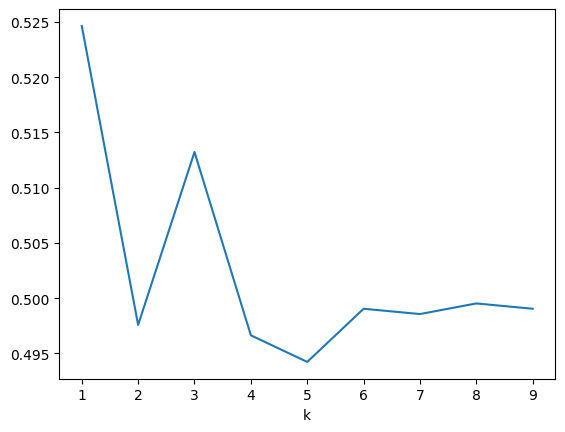

In [220]:
plt.plot(grid, scores, label="auc")
#plt.plot(grid, scores["precision"], label="precision")
#plt.plot(grid, scores["f1"], label="f1")
plt.xlabel('k')

plt.show()


In [14]:
from scipy import optimize

In [15]:
class KernelSvmClassifier:
    
    def __init__(self, C = 1.):
        self.C = C                               
        self.alpha = None
        self.supportVectors = None
    
    def fit(self, K, y):
        N = len(y)
        # --->
        # Gram matrix of h(x) y
        hXX = K
        yp = y.reshape(-1, 1)
        print(np.matmul(yp, yp.T).shape )
        GramHXy = hXX * np.matmul(yp, yp.T) 
        # <---

        # Lagrange dual problem
        def Ld0(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

        # Partial derivate of Ld on alpha
        def Ld0dAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        A = np.vstack((-np.eye(N), np.eye(N)))             # <---
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))  # <---
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y),     'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Maximize by minimizing the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld0(GramHXy, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -Ld0dAlpha(GramHXy, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        # --->
        epsilon = 1e-8
        supportIndices = self.alpha > epsilon
        self.supportindices = supportIndices
        self.supportAlphaY = y[supportIndices] * self.alpha[supportIndices]
        # <---
        print(self.alpha)
        print(len(supportIndices))
    
    def predict(self, K):
        """ Predict y values in {-1, 1} """
        # --->
        def predict1(K):
            x1 = K[self.supportindices]
            x2 = x1 * self.supportAlphaY
            return np.sum(x2)
        
        d = np.apply_along_axis(predict1, 1, K)
        return d

In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

In [139]:
import numpy as np
import cvxopt

class SVM:
    def __init__(self, C=1.0, kernel='linear', degree=3, gamma=None, coef0=0.0, tol=1e-4):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.tol = tol

    def fit(self, K_train, y_train):
        n_samples = K_train.shape[0]
        self.y_train = y_train.astype(np.double)
        K_train = K_train.astype(np.double)

        P = cvxopt.matrix(np.outer(self.y_train, self.y_train) * K_train)
        q = cvxopt.matrix(-np.ones(n_samples))
        G_std = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h_std = cvxopt.matrix(np.zeros(n_samples))
        G_slack = cvxopt.matrix(np.diag(np.ones(n_samples)))
        h_slack = cvxopt.matrix(np.ones(n_samples) * self.C)

        G = cvxopt.matrix(np.vstack((G_std, G_slack)))
        h = cvxopt.matrix(np.vstack((h_std, h_slack)))
        A = cvxopt.matrix(self.y_train.reshape(1, -1))
        b = cvxopt.matrix(np.zeros(1))

        cvxopt.solvers.options['show_progress'] = True
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        alpha = np.array(solution['x']).reshape(-1)
        sv_idx = alpha > self.tol

        self.alpha = alpha[sv_idx]
        self.support_vectors = np.where(sv_idx)[0]
        self.bias = np.mean(self.y_train[sv_idx] - np.sum(K_train[sv_idx][:, sv_idx] * (self.alpha * self.y_train[sv_idx]), axis=0))

        return self
    
    def decision_function(self, K_test):
        if self.kernel == 'linear':
            return np.sum(K_test[:, self.support_vectors] * (self.alpha * self.y_train[self.support_vectors]), axis=1) + self.bias
        elif self.kernel == 'poly':
            kernel = np.power(self.gamma * np.dot(K_test[:, self.support_vectors], K_train[self.support_vectors].T) + self.coef0, self.degree)
            return np.sum(kernel * (self.alpha * self.y_train[self.support_vectors]), axis=1) + self.bias
        elif self.kernel == 'rbf':
            kernel = np.exp(-self.gamma * (K_test - 2 * np.dot(K_test[:, self.support_vectors], K_train[self.support_vectors].T) + np.dot(K_train[self.support_vectors], K_train[self.support_vectors].T)))
            return np.sum(kernel * (self.alpha * self.self.y_train[self.support_vectors]), axis=1) + self.bias

    def predict(self, K_test):
        return np.sign(self.decision_function(K_test))


In [140]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [141]:
def center_kernel(K):
    N = K.shape[0]
    I = np.eye(N)
    return I - 1/N * np.ones((N, N)) @ K @ np.ones((N, N))

def normalize_kernel(K):
    N = K.shape[0]
    I = np.eye(N)
    return I - 1/N * np.ones((N, N)) @ K @ np.ones((N, N)) @ K @ np.ones((N, N))


#K_train_test = center_kernel(K_train_test)

In [82]:
train_labels = 2 * train_labels - 1

In [100]:
K_train = K_train[:,::-1]

In [166]:
train_labels

array([-1, -1, -1, ..., -1, -1, -1])

In [167]:
svm_ = SVM(kernel='linear', C=1.0)
_score = []
_conf_mat = []
for train_index, test_index in tqdm(skf.split(train_data, train_labels)):
        K_train_eval = K_train[train_index][:, train_index]
        #K_test_eval =normalize_kernel( K_train[test_index][:, test_index])
        K_train_test_eval = K_train[train_index][:, test_index]
        y_train_eval = train_labels[train_index]
        #print(K_train_eval.shape, K_test_eval.shape, K_train_test_eval.shape, y_train_eval.shape)
        alphas, y, ind, b = train(K_train_eval, y_train_eval)
        y_pred = predict(K_train_test_eval, alphas, y, ind, b)
        # y_pred = svm_.fit(K_train_eval, y_train_eval)
        # clss = np.abs(y_pred).argmax(axis=1)
        # y_pred = y_pred[np.arange(len(y_pred)), clss]
        y_test_eval = train_labels[test_index]
        _score.append(roc_auc_score(y_test_eval, y_pred))


0it [00:00, ?it/s]

     pcost       dcost       gap    pres   dres
 0: -9.9392e+02 -1.2458e+04  8e+04  3e+00  8e-12
 1: -6.6291e+02 -8.1260e+03  2e+04  5e-01  8e-12
 2: -5.7799e+02 -4.7961e+03  7e+03  2e-01  6e-12
 3: -5.7052e+02 -2.0571e+03  2e+03  4e-02  5e-12
 4: -6.0563e+02 -1.3121e+03  8e+02  1e-02  5e-12
 5: -6.4022e+02 -1.0224e+03  4e+02  6e-03  5e-12
 6: -6.5051e+02 -9.5843e+02  3e+02  4e-03  5e-12
 7: -6.6890e+02 -8.5084e+02  2e+02  1e-03  6e-12
 8: -6.7725e+02 -8.1321e+02  1e+02  6e-04  5e-12
 9: -6.8954e+02 -7.6718e+02  8e+01  2e-04  6e-12
10: -6.9369e+02 -7.5367e+02  6e+01  1e-04  5e-12
11: -6.9998e+02 -7.3565e+02  4e+01  6e-05  6e-12
12: -7.0459e+02 -7.2360e+02  2e+01  2e-05  6e-12
13: -7.0589e+02 -7.2042e+02  1e+01  8e-06  6e-12
14: -7.0864e+02 -7.1518e+02  7e+00  3e-06  6e-12
15: -7.0992e+02 -7.1273e+02  3e+00  3e-07  7e-12
16: -7.1035e+02 -7.1210e+02  2e+00  1e-07  6e-12
17: -7.1096e+02 -7.1129e+02  3e-01  1e-08  6e-12
18: -7.1108e+02 -7.1113e+02  5e-02  1e-09  6e-12
19: -7.1110e+02 -7.11

1it [01:17, 77.96s/it]

     pcost       dcost       gap    pres   dres
 0: -9.7160e+02 -1.1429e+04  7e+04  3e+00  7e-12
 1: -6.6851e+02 -7.4893e+03  2e+04  6e-01  7e-12
 2: -5.7926e+02 -3.5426e+03  5e+03  1e-01  5e-12
 3: -5.8229e+02 -1.6420e+03  1e+03  3e-02  5e-12
 4: -6.2188e+02 -1.0817e+03  5e+02  1e-02  5e-12
 5: -6.3598e+02 -9.9491e+02  4e+02  7e-03  5e-12
 6: -6.5710e+02 -8.7588e+02  2e+02  4e-03  5e-12
 7: -6.6864e+02 -8.2145e+02  2e+02  2e-03  5e-12
 8: -6.7700e+02 -7.8767e+02  1e+02  1e-03  5e-12
 9: -6.8786e+02 -7.4652e+02  6e+01  4e-04  5e-12
10: -6.9504e+02 -7.2302e+02  3e+01  4e-05  5e-12
11: -6.9567e+02 -7.2145e+02  3e+01  2e-05  5e-12
12: -6.9968e+02 -7.1351e+02  1e+01  1e-05  5e-12
13: -7.0241e+02 -7.0821e+02  6e+00  1e-06  5e-12
14: -7.0250e+02 -7.0792e+02  5e+00  9e-07  5e-12
15: -7.0421e+02 -7.0540e+02  1e+00  8e-08  5e-12
16: -7.0454e+02 -7.0495e+02  4e-01  2e-08  5e-12
17: -7.0471e+02 -7.0474e+02  3e-02  9e-11  6e-12
18: -7.0472e+02 -7.0472e+02  1e-03  4e-12  6e-12
19: -7.0472e+02 -7.04

2it [02:36, 78.33s/it]

     pcost       dcost       gap    pres   dres
 0: -9.8146e+02 -1.1581e+04  7e+04  3e+00  8e-12
 1: -6.7932e+02 -7.6811e+03  2e+04  6e-01  7e-12
 2: -5.8216e+02 -3.9666e+03  5e+03  1e-01  6e-12
 3: -5.8372e+02 -1.6824e+03  1e+03  3e-02  6e-12
 4: -6.2134e+02 -1.1924e+03  7e+02  1e-02  6e-12
 5: -6.5211e+02 -9.7025e+02  4e+02  6e-03  6e-12
 6: -6.6705e+02 -8.8169e+02  2e+02  2e-03  6e-12
 7: -6.7150e+02 -8.5784e+02  2e+02  2e-03  6e-12
 8: -6.8862e+02 -7.8800e+02  1e+02  6e-04  6e-12
 9: -6.9576e+02 -7.6517e+02  7e+01  3e-04  6e-12
10: -7.0111e+02 -7.4392e+02  4e+01  4e-14  8e-12
11: -7.0700e+02 -7.2994e+02  2e+01  3e-13  7e-12
12: -7.1075e+02 -7.2254e+02  1e+01  9e-14  7e-12
13: -7.1286e+02 -7.1884e+02  6e+00  1e-13  7e-12
14: -7.1446e+02 -7.1626e+02  2e+00  6e-14  7e-12
15: -7.1502e+02 -7.1546e+02  4e-01  1e-13  7e-12
16: -7.1519e+02 -7.1523e+02  4e-02  1e-13  8e-12
17: -7.1521e+02 -7.1521e+02  1e-03  1e-13  8e-12


3it [03:48, 75.60s/it]

18: -7.1521e+02 -7.1521e+02  2e-05  8e-14  8e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0035e+03 -1.2101e+04  7e+04  3e+00  9e-12
 1: -6.8907e+02 -7.9950e+03  2e+04  6e-01  7e-12
 2: -5.9600e+02 -3.6534e+03  5e+03  1e-01  6e-12
 3: -6.0464e+02 -1.6736e+03  1e+03  3e-02  5e-12
 4: -6.4030e+02 -1.2167e+03  7e+02  1e-02  6e-12
 5: -6.6751e+02 -1.0151e+03  4e+02  6e-03  6e-12
 6: -6.7676e+02 -9.6189e+02  3e+02  5e-03  5e-12
 7: -6.9402e+02 -8.7405e+02  2e+02  2e-03  6e-12
 8: -7.0693e+02 -8.1485e+02  1e+02  1e-03  6e-12
 9: -7.1405e+02 -7.7836e+02  6e+01  7e-05  7e-12
10: -7.1676e+02 -7.7177e+02  6e+01  5e-05  6e-12
11: -7.2025e+02 -7.5930e+02  4e+01  2e-14  7e-12
12: -7.2653e+02 -7.4669e+02  2e+01  2e-14  6e-12
13: -7.2960e+02 -7.4053e+02  1e+01  2e-14  6e-12
14: -7.3093e+02 -7.3808e+02  7e+00  3e-14  6e-12
15: -7.3263e+02 -7.3531e+02  3e+00  4e-14  6e-12
16: -7.3297e+02 -7.3470e+02  2e+00  5e-15  7e-12
17: -7.3355e+02 -7.3397e+02  4e-01  7e-14  6e-

4it [05:05, 75.84s/it]

20: -7.3374e+02 -7.3374e+02  1e-05  1e-13  7e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9435e+02 -1.1884e+04  7e+04  3e+00  8e-12
 1: -6.8506e+02 -7.7998e+03  2e+04  6e-01  7e-12
 2: -5.9729e+02 -3.6697e+03  5e+03  1e-01  6e-12
 3: -5.9354e+02 -1.9205e+03  2e+03  4e-02  5e-12
 4: -6.3322e+02 -1.1762e+03  6e+02  1e-02  5e-12
 5: -6.5990e+02 -9.8759e+02  4e+02  6e-03  5e-12
 6: -6.8243e+02 -8.6422e+02  2e+02  2e-03  5e-12
 7: -6.9614e+02 -8.0522e+02  1e+02  1e-03  6e-12
 8: -7.0531e+02 -7.7415e+02  7e+01  5e-04  6e-12
 9: -7.1074e+02 -7.5848e+02  5e+01  3e-04  6e-12
10: -7.1679e+02 -7.4292e+02  3e+01  1e-04  6e-12
11: -7.1857e+02 -7.3793e+02  2e+01  6e-05  6e-12
12: -7.2250e+02 -7.3026e+02  8e+00  2e-05  6e-12
13: -7.2318e+02 -7.2821e+02  5e+00  6e-14  7e-12
14: -7.2501e+02 -7.2588e+02  9e-01  1e-14  7e-12
15: -7.2535e+02 -7.2545e+02  9e-02  2e-13  7e-12
16: -7.2539e+02 -7.2540e+02  9e-03  1e-13  7e-12
17: -7.2540e+02 -7.2540e+02  2e-04  1e-13  7e-

5it [06:11, 74.36s/it]


In [ ]:
import numpy as np
from scipy.optimize import minimize
from cvxopt import matrix, solvers

def svm_solver(K, y, C=1.0):
    n_samples = K.shape[0]
    P = np.outer(y, y) * K
    q = -np.ones(n_samples)
    G = np.vstack((-np.eye(n_samples), np.eye(n_samples)))
    h = np.hstack((np.zeros(n_samples), C * np.ones(n_samples)))
    A = y[np.newaxis, :].astype('float64')
    b = np.zeros(1)

    P = matrix(P)
    q = matrix(q)
    G = matrix(G)
    h = matrix(h)
    A = matrix(A)
    b = matrix(b)

    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x']).flatten()
    
    return alphas

def train(K, y, C=1.0):
    alphas = svm_solver(K, y, C)
    support_vectors = alphas > 1e-6
    ind = np.arange(len(alphas))[support_vectors]
    alphas = alphas[support_vectors]
    support_y = y[support_vectors]
    support_K = K[ind][:, support_vectors]
    
    b = np.mean(support_y - np.sum(support_K * alphas * support_y, axis=1))
    
    return alphas, support_y, ind, b

def predict(K_test, alphas, support_y, ind, b):
    logits = np.dot(K_test[ind].T, alphas * support_y) + b
    return logits

# Exemple d'utilisation :
# Charger les données et les noyaux précalculés ici
# K, K_test, y et y_test doivent être chargés ou générés


In [78]:
K_train_test_eval.min()

0.0

In [168]:
print(np.mean(_score))

0.8557028102482647


In [70]:
np.array([[1, 4, 3]]).reshape(3,1).flatten()

array([1, 4, 3])

In [170]:
print(_conf_mat)

[]


In [169]:
import pandas as pd
alphas, y, ind, b = train(K_train, train_labels)
y_pred = predict(K_train_test.T, alphas, y, ind, b)
Yte = {'Predicted' : y_pred} 
dataframe = pd.DataFrame(Yte) 
dataframe.index += 1 
dataframe.to_csv('test_pred.csv',index_label='Id')

     pcost       dcost       gap    pres   dres
 0: -1.2500e+03 -1.5719e+04  1e+05  3e+00  1e-11
 1: -8.5331e+02 -1.0531e+04  2e+04  6e-01  1e-11
 2: -7.3664e+02 -5.1658e+03  7e+03  1e-01  8e-12
 3: -7.3515e+02 -2.2394e+03  2e+03  3e-02  8e-12
 4: -7.8383e+02 -1.5321e+03  9e+02  1e-02  7e-12
 5: -8.0701e+02 -1.3535e+03  6e+02  8e-03  7e-12
 6: -8.2331e+02 -1.2483e+03  5e+02  5e-03  7e-12
 7: -8.4857e+02 -1.1013e+03  3e+02  3e-03  7e-12
 8: -8.5867e+02 -1.0484e+03  2e+02  1e-03  7e-12
 9: -8.7603e+02 -9.7978e+02  1e+02  5e-04  8e-12
10: -8.8030e+02 -9.6450e+02  9e+01  3e-04  8e-12
11: -8.8610e+02 -9.3936e+02  5e+01  2e-14  9e-12
12: -8.9328e+02 -9.2381e+02  3e+01  1e-14  8e-12
13: -8.9604e+02 -9.1845e+02  2e+01  2e-13  8e-12
14: -8.9845e+02 -9.1303e+02  1e+01  3e-13  9e-12
15: -8.9922e+02 -9.1155e+02  1e+01  4e-14  8e-12
16: -9.0129e+02 -9.0823e+02  7e+00  7e-14  8e-12
17: -9.0193e+02 -9.0708e+02  5e+00  5e-14  8e-12
18: -9.0333e+02 -9.0515e+02  2e+00  3e-13  9e-12
19: -9.0395e+02 -9.04

In [121]:

%load_ext autoreload
%autoreload 2

In [210]:
from src.kernels import GraphHistogramKernel, RandomWalkKernel, LinearEdgeKernel, BinaryNodeKernel, ShortestPathKernel

In [211]:
kern = ShortestPathKernel()

In [212]:
print(kern(train_data[:10], train_data[:10]))

[[0.11364746 0.09958225 0.10426312 0.09188476 0.10542297 0.09828125
  0.12350502 0.08722656 0.10168651 0.06136719]
 [0.09958225 0.09548611 0.09379287 0.08511568 0.09484185 0.08940972
  0.10744599 0.08111111 0.09302564 0.05985243]
 [0.10426312 0.09379287 0.09868922 0.08821662 0.09784915 0.09398148
  0.11149215 0.0837037  0.09581199 0.06193673]
 [0.09188476 0.08511568 0.08821662 0.0872107  0.09307923 0.08481175
  0.09507533 0.07886134 0.09073835 0.06407484]
 [0.10542297 0.09484185 0.09784915 0.09307923 0.10739899 0.09380859
  0.12084057 0.08599609 0.10088931 0.06379395]
 [0.09828125 0.08940972 0.09398148 0.08481175 0.09380859 0.0908
  0.1066358  0.0815     0.09122449 0.0619625 ]
 [0.12350502 0.10744599 0.11149215 0.09507533 0.12084057 0.1066358
  0.15904588 0.09540123 0.11104112 0.0608179 ]
 [0.08722656 0.08111111 0.0837037  0.07886134 0.08599609 0.0815
  0.09540123 0.0766     0.08362812 0.06143125]
 [0.10168651 0.09302564 0.09581199 0.09073835 0.10088931 0.09122449
  0.11104112 0.083628

In [177]:
train_data = np.array(train_data, dtype=object)

In [187]:
pos_data = train_data[train_labels == 1]
neg_data = train_data[np.random.choice(np.arange(0, train_data.shape[0]), size=pos_data.shape[0], replace=False)]

train_data_short = np.concatenate([pos_data, neg_data])
train_labels_short = np.concatenate([np.ones(pos_data.shape[0]), np.zeros(neg_data.shape[0])])

In [214]:
K_train = kern(train_data_short, train_data_short)

In [215]:
np.save('K_train_shortest_path.npy', K_train)

In [216]:
K_train_test = kern(train_data_short, test_data)

np.save('K_train_test_shortest_path.npy', K_train_test)



In [217]:
K_test = np.diag([kern(x,x) for x in tqdm(test_data)] )

np.save('K_test_shortest_path.npy', K_test)

100%|██████████| 2000/2000 [00:03<00:00, 502.93it/s]


In [221]:
np.save('train_labels_short.npy', train_labels_short)